# Feature Selection

**Goal**: Given the impracticality and risks associated with training a model on a full set of genes, identify a subset of features that is highly discriminating between male and female cells.

**Output**: Set of features to be used in subsequent steps

**TODO**:
- Extend to principal components as a means of feature reduction
- Add feature set membership as T/F feature

In [8]:

# Import needed libraries
from sklearn.model_selection import StratifiedShuffleSplit

import scanpy as sc
import numpy as np
import pandas as pd
import os
import pathlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from utils.config import *
from utils.analysis_variables import *
from utils.analysis_functions import *

import pickle

from sklearn.feature_selection import SelectKBest, GenericUnivariateSelect, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, confusion_matrix


In [9]:
# Scanpy setup
sc.settings.verbosity = 3 # corresponds to hints

# Notebook setup
np.random.seed(15)

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Important paths
notebook_name = "04_feature_selection"

# path_outdir_base = "../../output/20240221_import"
path_results = os.path.join(path_outdir_base, notebook_name)
os.makedirs(path_results, exist_ok=True)

path_input_data = os.path.join(path_outdir_base, "03_create_test_train", "training_data.pkl")
path_input_adata = os.path.join(path_outdir_base, "03_create_test_train", "adata_labeled.h5ad")

In [11]:
os.listdir(os.path.join(path_outdir_base, "03_create_test_train"))

['adata_labeled.h5ad',
 'adata_unlabeled.h5ad',
 'test_data.pkl',
 'training_data.pkl']

# Import data

In [12]:
with open(path_input_data, 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X']
y_train = data_dict['Y']

In [13]:
adata_labeled = sc.read_h5ad(path_input_adata)

KeyboardInterrupt: 

# Method One: Variance Thresholding


Removes all genes that do not meet a variance threshold.

Although it could be implemented with VarianceThreshold, A version of this has already been implemented by [scanpy highly_variable_genes](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) (labels in adata.var.highly_variable).

For each bin of mean expression, highly variable genes are selected. First, data are standardized via z-score normalization for each gene/feature. Then, normalized variance is computed as the variance of each gene after transofrmation. Genes are ranked, and those with a minimum dispersion of 0.5 are called highly variable.

# Univariate Feature Selection

## Select K Best Features
Selects features according to the K best scores using an F-test.
1. calculation of F-statistic: measures ratio (between group variance AKA variance between group means)/(within group variance AKA variance within group)
2. Calculation of p-value, which represents probability of obtaining an F-statistic as extreme as the one observed if null were true
3. Features are ranked according to p value and top k features are selected

"The methods based on F-test estimate the degree of linear dependency between two random variables."

Note that my goal is simply to get the feature names corresponding to the identified features so I'm using the original dataset rather than X_train out of convenience rather than the transformed X_train dataset.

In [ ]:
# retrieve the 100 best features for a dataset 

def nominate_k_best_features(adata_labeled, k_chosen):

    select_k_best = SelectKBest(f_classif, k=k_chosen) # Function returning scores - here, F statistic

    X_new = select_k_best.fit_transform(adata_labeled.X.toarray(), 
                                        adata_labeled.obs.Sex.cat.codes.values,) 

    features_select_k_best = select_k_best.get_feature_names_out(input_features=adata_labeled.to_df().columns.to_list())

    # returns univariate scores and p-values 
    print(f"Nominating {k_chosen} best features:")
    print(f"Size of K Best features matrix (cells x genes): {X_new.shape}")
    print(f"Sample feature names: {features_select_k_best[0:5]}")

    return(features_select_k_best, select_k_best)

features_select_k_best_100, _ = nominate_k_best_features(adata_labeled=adata_labeled, k_chosen=100)
features_select_k_best_200, select_k_best = nominate_k_best_features(adata_labeled=adata_labeled, k_chosen=200)


KeyboardInterrupt: 

In [ ]:
# quite possible that just selecting top 100 is overconstraining - what if we selected everything with significant pvalue according to this ranking metric?
select_k_best_pvals = pd.DataFrame(data={"gene":adata_labeled.to_df().columns.to_list(),
                                         "pval":select_k_best.pvalues_}).sort_values('pval', ascending=True)

features_select_k_best_signif = select_k_best_pvals[select_k_best_pvals['pval']< 0.05].sort_values('pval')['gene'].to_list()

print(f"Number of genes with pvalues less than 0.05: {len(features_select_k_best_signif)}") 


Number of genes with pvalues less than 0.05: 6596


## GenericUnivariateSelect

Generic Univariate Selection is different from selection of K best features in that it is a bit more flexible than SelectKBest.

SelectKBest takes in a scoring function (chi-squared, F classif, etc.) and evaluates each feature independently, finally selecting the top k features with the highest scores.

GenericUnivariateSelect is more flexible in that it lets you choose both the scoring function AND how the evaluation takes place (e.g. top k best, or percentile). GenericUnivariateSelect can do what SelectKBest does, but it can be better integrated into a pipeline to assay what the best method for evaluation is when it comes to selecting features for an effective classifier.

The feature selection modes used for generic univariate selection:
- K-best: Select the top k features with the best score given your scoring function - you specify what number "k" is
- Percentile: Selects the top N% of features to retain - you specify what N is
- FPR/False Positive Rate: Selects features such that the false positive rate is below a certain threshold
- FDR/False Discovery Rate: Selects features such that the false positive is controlled (via controlling the number of false disoveries)
- FWE/Familywise error: Controls the probability of making one or more false discoveries among a set of tests

Some scorers include:
- f_classif: Fisher's Linear Discriminant Analysis - assess statistical significance of difference between the mean values of different classes of a categorical target variable. Claculates F-statistic for each feature

What does it mean to select features to control the false positive rate?
- Goal: limit the chances of including irrelevant features in your selection
- False Positive Rate of 5%: Willing to accept a 5% probability that a positive is a false positive, i.e. not actually informative or relevant to the target variable

The difference between controlling false positives and controlling false discoveries:
- False discovery: when you incorrectly claim to discover a significant result/relationship when it is not present. False positive is for an INDIVIDUAL feature incorrectly identified as relevant, whereas false discovery is the broader concept of making incorrect claims of significance within a set of features
- Limit the overall rate of incorrect claims of significance across all tests

### Generic Univariate Select: Default scoring function (mean accuracy), five different evaluation models

First, figure out what produces the best feature set; then, use GenericUnivariateSelect() to select the best features.

I am worried about becoming very accurate but also increasing the specificty, false positive rate, or false negative rate. Therefore, I will specify the scoring parameter.

In [ ]:
# Define different evaluation modes for univariate selection
param_grid=[{
    'feature_selection__mode': ['k_best', 'percentile', 'fpr', 'fdr', 'fwe']
}]

# Evaluate how features do on an SVC-based classification task
pipeline = Pipeline([
    ('feature_selection', GenericUnivariateSelect()), # to make transformer
    ('classification', SVC())
])


# Create metrics for measuring performance of classifier (and using this to judge the scorer/estimator combo in GenericUnivariateSelection)
# Define a function to calculate specificity
scoring = {
    'accuracy': 'accuracy',  # Default scoring for classification
    'specificity': make_scorer(specificity),
    'false_positive_rate': make_scorer(false_positive_rate, greater_is_better=False),  # Minimize false positive rate
    'false_negative_rate': make_scorer(false_negative_rate, greater_is_better=False),  # Minimize false negative rate; something funny abt this processing makes this neg
    'precision': make_scorer(precision)
}

# # Calculate specificity using cross_val_score
# specificity_scores = cross_val_score(svc_model, X, y, cv=5, scoring=make_scorer(specificity))
# print("Specificity Scores:", specificity_scores)

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=scoring, refit='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_selection',
                                        GenericUnivariateSelect()),
                                       ('classification', SVC())]),
             param_grid=[{'feature_selection__mode': ['k_best', 'percentile',
                                                      'fpr', 'fdr', 'fwe']}],
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'false_negative_rate': make_scorer(false_negative_rate, greater_is_better=False),
                      'false_positive_rate': make_scorer(false_positive_rate, greater_is_better=False),
                      'precision': make_scorer(precision),
                      'specificity': make_scorer(specificity)})

In [ ]:

print("Best Parameters:", grid_search.best_params_)
cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results['mean_test_precision'], cv_results['params']):
    print(f"Mean Test Precision: {mean_score:.3f}, Parameters: {params}")


Best Parameters: {'feature_selection__mode': 'fdr'}
Mean Test Precision: nan, Parameters: {'feature_selection__mode': 'k_best'}
Mean Test Precision: 0.853, Parameters: {'feature_selection__mode': 'percentile'}
Mean Test Precision: 0.978, Parameters: {'feature_selection__mode': 'fpr'}
Mean Test Precision: 0.977, Parameters: {'feature_selection__mode': 'fdr'}
Mean Test Precision: 0.972, Parameters: {'feature_selection__mode': 'fwe'}


In [ ]:
# For ease of use, create pandas matrix 
cv_results_df = pd.DataFrame(grid_search.cv_results_)

Examining feature selection, consistently observed:
- FPR, FDR, and FWE performed much better (like 97%) rather than k_best or percentile
- However they also take much longer (~3 seconds for the first two, 17 for FPR, 13 for FDR, 8.2 for FWE)

Typically, when it says "score", by default, this is inherited from the classification function - here, SVC(), for which the default score is mean accuracy (ratio of correctly predicted instances to the total instances in the dataset).

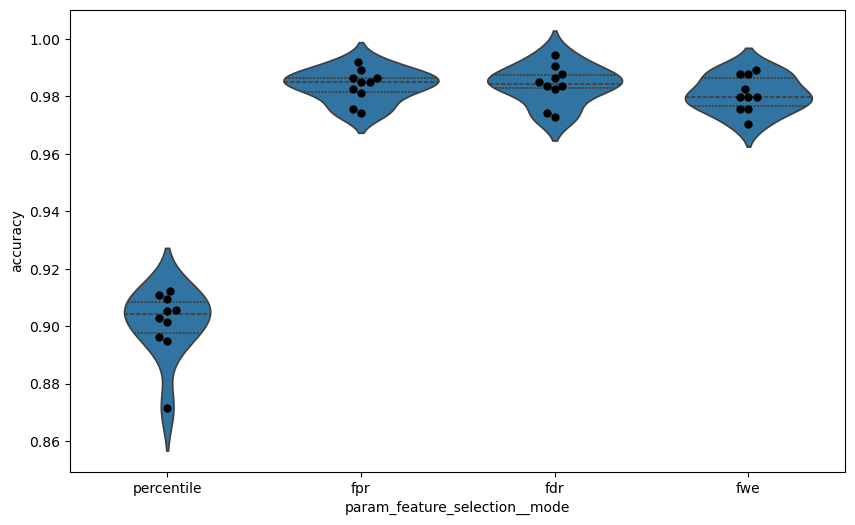

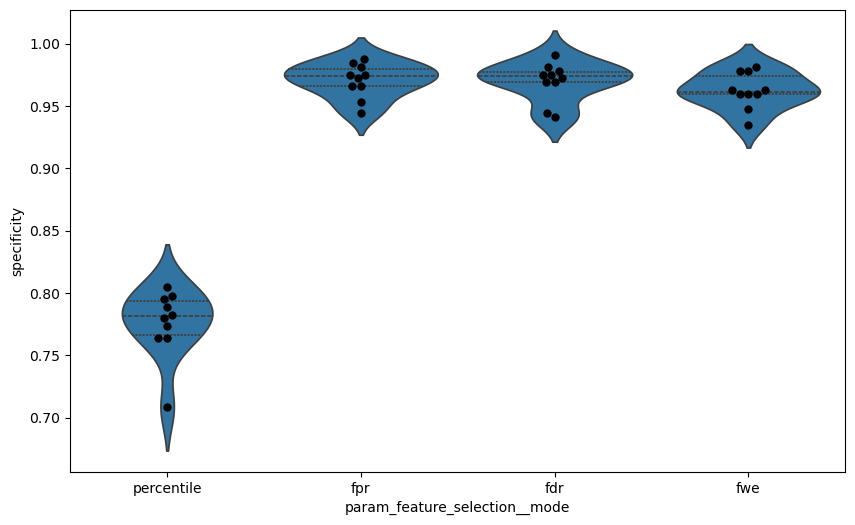

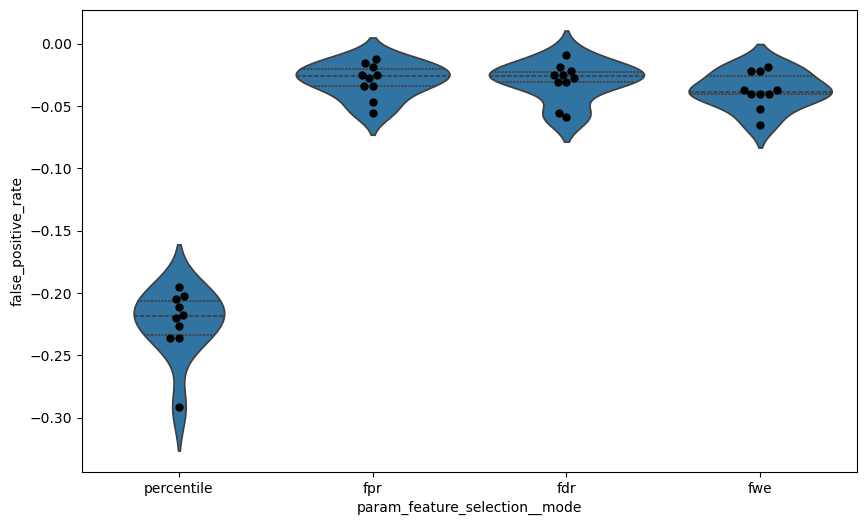

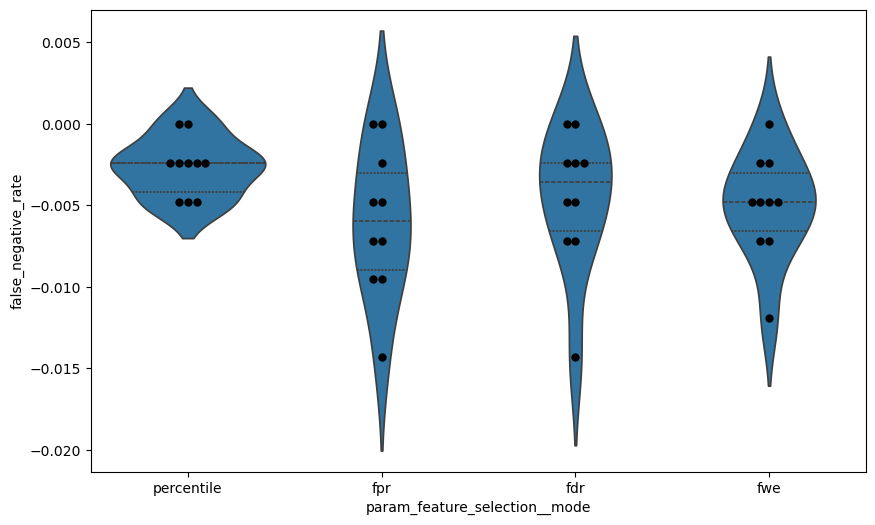

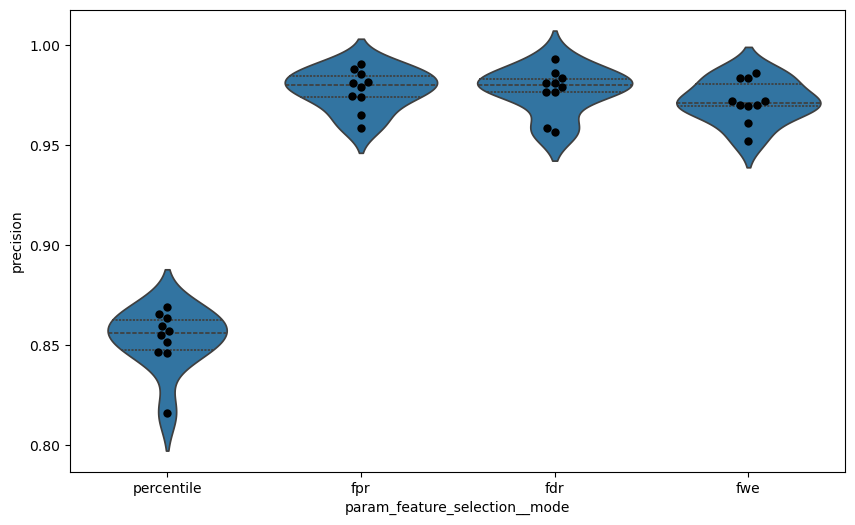

In [ ]:
# for each scorer, make a plot over each split graphing performance
import seaborn as sns
import matplotlib.pyplot as plt

for metric in list(scoring.keys()):
    pattern = rf'split\d+_test_{metric}'
    matched_columns = cv_results_df.filter(regex=pattern, axis=1).columns.tolist()
    subset_df2 = cv_results_df[['param_feature_selection__mode'] + matched_columns].dropna()
    subset_df2_long = pd.melt(subset_df2, id_vars=['param_feature_selection__mode'], var_name='split', value_name=metric).dropna()

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(x="param_feature_selection__mode", y=metric, data=subset_df2_long, ax=ax, inner="quartile")
    sns.swarmplot(
        x='param_feature_selection__mode',
        y=metric,
        data=subset_df2_long,
        color='black',  # Color of the data points
        size=6,  # Size of the data points
        ax=ax,  # Use the same axes as the violin plot
    )

### Now that estimator chosen, extract features

In [ ]:
# Access the best estimator with the best parameters
best_estimator = grid_search.best_estimator_

# Use this best estimator to select features
feature_selector = GenericUnivariateSelect(score_func=f_classif, mode = 'fpr')
# X_train_selected = feature_selector.fit_transform(X_train, y_train)

X_train_selected = feature_selector.fit_transform(adata_labeled.X.toarray(), adata_labeled.obs.Sex.cat.codes.values)

features_select_fpr_ftest = feature_selector.get_feature_names_out(adata_labeled.to_df().columns.to_list())

# # Use the mask to get the selected features
# selected_features_mask = feature_selector.get_support()  # Get the boolean mask of selected features
# selected_features_array = X_train[:, selected_features_mask]

# returns univariate scores and p-values 
print(f"Size of exprs mtx: {adata_labeled.X.shape}") # cells, genes
print(f"Size of Best features mtx: {X_train_selected.shape}")
print(f"Feature names: {features_select_fpr_ftest}")
print(f"N Feature names: {len(features_select_fpr_ftest)}")



Size of exprs mtx: (9259, 20821)
Size of Best features mtx: (9259, 2039)
Feature names: ['Atp6v1h' 'Kcnb2' 'Terf1' ... 'mt-Nd5' 'mt-Cytb' 'PISD']
N Feature names: 2039


In [ ]:
# Choose a more modest number of features to account for the fact that I don't have very much training data
## Worried that this forces FPR to be so low - may lead to higher false negative rate

# Use this best estimator to select features
feature_selector_small = GenericUnivariateSelect(score_func=f_classif, mode = 'fpr', param = 5e-20) # param represents alpha for FPR

X_train_selected_small = feature_selector_small.fit_transform(adata_labeled.X.toarray(), adata_labeled.obs.Sex.cat.codes.values)

features_select_fpr_ftest_200 = feature_selector_small.get_feature_names_out(adata_labeled.to_df().columns.to_list())

# returns univariate scores and p-values 
print(f"Size of exprs mtx: {adata_labeled.X.shape}") # cells, genes
print(f"Size of X_train_selected_small features mtx: {X_train_selected_small.shape}")
print(f"Some feature names: {features_select_fpr_ftest_200[0:5]}")
print(f"N Feature names: {len(features_select_fpr_ftest_200)}")



Size of exprs mtx: (9259, 20821)
Size of X_train_selected_small features mtx: (9259, 266)
Some feature names: ['Rpl7' 'Rpl31' 'Map4k4' 'Clk1' 'Hjurp']
N Feature names: 266


# Upset Plot


In [ ]:


adata_labeled.var['gene_mt'] = adata_labeled.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata_labeled.var['gene_hsp'] = adata_labeled.var_names.str.startswith('Hsp')  # annotate the group of mitochondrial genes as 'mt'
adata_labeled.var['gene_ribo'] = adata_labeled.var_names.str.startswith(('Rpl', 'Rps'))  # annotate the group of mitochondrial genes as 'mt'
adata_labeled.var['gene_hemo'] = adata_labeled.var_names.str.startswith(('Hbb', 'Hba'))  # annotate the group of mitochondrial genes as 'mt'


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

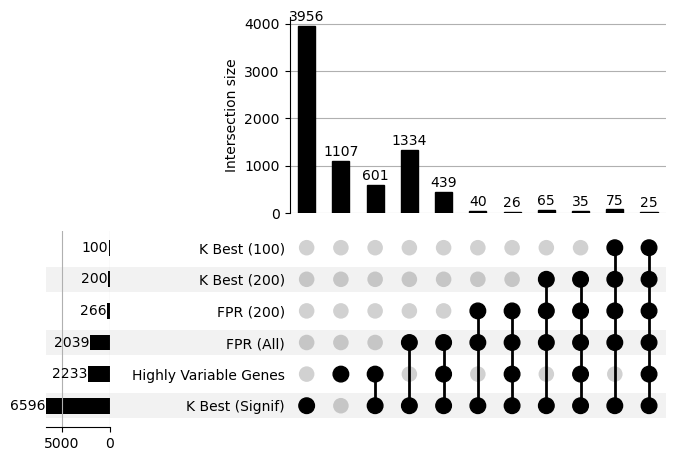

In [ ]:
import pandas as pd
from upsetplot import UpSet, from_contents

# Create a sample dataset
dict_feature_data = {
    'Highly Variable Genes': adata_labeled.var[adata_labeled.var.highly_variable].index.tolist(),
    'K Best (100)': features_select_k_best_100,
    'K Best (200)': features_select_k_best_200,
    'K Best (Signif)': features_select_k_best_signif,
    'FPR (All)': features_select_fpr_ftest,
    'FPR (200)': features_select_fpr_ftest_200,
    'All Sexually Dimorphic Genes': adata_labeled.var.msigdb_all_sex_dimorph_genes.to_list()
}

feature_sets = from_contents(dict_feature_data)

# Create an UpSet object
upset = UpSet(feature_sets, show_counts=True)

# Plot the UpSet plot
upset.plot()

# Save feature sets of interest

In [ ]:

with open(os.path.join(path_results, 'dict_feature_data.pkl'), 'wb') as file:
    pickle.dump(dict_feature_data, file)